#  MelodyMaster
## Notebook01 - Exploring, Preprocessing & Splitting the data
### Idan Kashani & Or Raphael Bidusa

# Welcome!
This is the first notebook out of many as a part of our project to course number 234313 at the CS faculty in the technion.
The main goal of the project is to build a classifier which can classify an artist given a song.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ast
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

We will use a dataset from [kaggle](https://www.kaggle.com/datasets/guybarash/hebrew-songs-lyrics) of around ~15,000 songs.
The songs were scrapped from [shironet's website](https://shironet.mako.co.il/) and contains 167 different artists.

In [2]:
df = pd.read_csv('./dataset.csv')
print("The shape of the dataset is: ", df.shape)

The shape of the dataset is:  (14765, 7)


First, we will alter the columns' names to match our needs.
For example, instead of 'songs' which is represented by a long string - the song itself, we will change the column's name to 'lyrics'.

In [3]:
df = df.rename(columns={"songs": "lyrics", "song": "song_name"})

In [4]:
df.sample(5)

,artist,lyrics,song_name,artist_key,url,words count,unique words count
1743,אבי טולדנו,"['את', 'יושבת', 'לך', 'שעות', 'רבות', 'מול', '...",תרקדי את הלילה,Artist_Avi_Toledano,http://shironet.mako.co.il/artist?type=lyrics&...,97,63
12415,סטטיק ובן אל תבורי,"['בן', 'אל', 'תבוריניו', 'סטטובום', ""ג'ורדלאצ'...",טודו בום,Artist_Static_and_ben_el_tavori,http://shironet.mako.co.il/artist?type=lyrics&...,274,134
1593,אבי ביטר,"['יום', 'שישי', 'בערב', ""החבר'ה"", 'ניפגשים', '...",פגישה שבועית,Artist_Avi_Bitter,http://shironet.mako.co.il/artist?type=lyrics&...,114,91
1858,בית הבובות,"['מחלפותיו', 'בלויים', 'הוא', 'קבצן', 'הם', 'ל...",משיח,Artist_Beit_Ha_Bubot,http://shironet.mako.co.il/artist?type=lyrics&...,89,62
13651,יהודית רביץ,"['יו', 'ים', 'הו', 'יו', 'ים', 'יר', 'יר', 'יכ...",מאחורי השער,Artist_Yehudit_Ravitz,http://shironet.mako.co.il/artist?type=lyrics&...,23,12


In [5]:
df.dtypes

artist                object
lyrics                object
song_name             object
artist_key            object
url                   object
words count            int64
unique words count     int64
dtype: object

As can be seen above, there are 7 features for each sample - however we will focus on 3 features.
'artist' - an artist that had covered the song (not necessarily the writer itself), this will be the label we'll try to predict.
'song_name', 'lyrics' - the name of the song and a list of the lyrics, which will help us classify the artist.

### But first, let's see some statistics

In [6]:
df.describe()

,words count,unique words count
count,14765.000000,14765.000000
mean,112.443210,70.598171
std,61.125532,36.340199
min,0.000000,0.000000
25%,78.000000,50.000000
50%,101.000000,65.000000
75%,134.000000,83.000000
max,771.000000,456.000000


## The Empty Song
#### Wait, a minimum word count of 0?!
The dataset itself is not 'clean', some lyrics are empty lists because the original song had lyrics only in English.
Furthermore, some songs have more than one artist which can make the task a bit more complicated.
Some artists have too few songs which makes the task of classifying the artist unreasonable.
This entire part shall deal with these problems.
**By thus we are not altering the data itself**, but defining the problem itself, the rules, the data - to match the task.

In [7]:
# Clean empty songs (songs with non-hebrew lyrics)
cleaned_df = df[df['lyrics'] != '[]']
print(f"Total number of songs: {len(cleaned_df)} (was: {len(df)})")

Total number of songs: 14543 (was: 14765)


## Niqqud is Rude
Niqqud, according to [Wikipedia](https://en.wikipedia.org/wiki/Niqqud) is a system of diacritical signs used to represent vowels or distinguish between alternative pronunciations of letters of the Hebrew alphabet.
The tokenization (that was already done by the creators of the dataset) was done by separating words using non-hebrew-encoded characters, including Niqqud :(
For songs with Niqqud, this resulted with a nonsense tokenization and a contaminated vocabulary.

In [8]:
print(f'The artist יהורם גאון has {len(cleaned_df[cleaned_df["artist"]=="יהורם גאון"])} songs')
cleaned_df[cleaned_df['song_name']=='ארץ צבי']

The artist יהורם גאון has 279 songs


,artist,lyrics,song_name,artist_key,url,words count,unique words count
13219,יהורם גאון,"['מו', 'עו', 'יקו', 'עו', 'יב', 'בו', 'דו', 'י...",ארץ צבי,Artist_Yehoram_Gaon,http://shironet.mako.co.il/artist?type=lyrics&...,59,33


The tokens "יר", "עו" or "יקו" are not legitimate Hebrew words.
To detect songs with Niqqud in order to discard them, we wrote a function that checks if more than 80% of the vocabulary of the song is made up of short words (less than 4 letters).
Notice the drop in the number of songs of יהורם גאון.

In [9]:
def niqqud_pred(lyrics_to_check):
    lyrics_to_check = ast.literal_eval(lyrics_to_check['lyrics'])
    short_words_count = sum(map(lambda x : len(x) < 4, lyrics_to_check))
    return short_words_count/len(lyrics_to_check)  < 0.8

cleaned_df = cleaned_df[cleaned_df.apply(lambda x: niqqud_pred(x), axis=1)]
print(f'The artist יהורם גאון has only {len(cleaned_df[cleaned_df["artist"]=="יהורם גאון"])} songs now')
cleaned_df[cleaned_df['song_name']=='ארץ צבי']

The artist יהורם גאון has only 273 songs now


,artist,lyrics,song_name,artist_key,url,words count,unique words count


## Cover Yourself Up
Unfortunately, the data set contains samples of artists and songs which were covered and by thus creating two samples with the same song but with different artist.
This makes our task a bit more completed, especially for defining metrics for calculating the accuracy.

In [10]:
# Duplicate songs
print("Number of Songs by the Number of Covers:")
print(cleaned_df['lyrics'].value_counts().value_counts())
cleaned_df[cleaned_df['song_name']=='פרח הלילך']

Number of Songs by the Number of Covers:
1     11084
2      1073
3       197
4        56
5        31
6        18
7         5
22        1
18        1
13        1
9         1
8         1
Name: lyrics, dtype: int64


,artist,lyrics,song_name,artist_key,url,words count,unique words count
883,אריק איינשטיין,"['היום', 'אולי', 'נדחה', 'את', 'בוא', 'הלילה',...",פרח הלילך,Artist_Arik_Einstien,http://shironet.mako.co.il/artist?type=lyrics&...,109,77
1054,אריק לביא,"['היום', 'אולי', 'נדחה', 'את', 'בוא', 'הלילה',...",פרח הלילך,Artist_Arik_lavi,http://shironet.mako.co.il/artist?type=lyrics&...,109,77
1158,אריק סיני,"['היום', 'אולי', 'נדחה', 'את', 'בוא', 'הלילה',...",פרח הלילך,Artist_Arik_Sinai,http://shironet.mako.co.il/artist?type=lyrics&...,109,77
5513,חוה אלברשטיין,"['היום', 'אולי', 'נדחה', 'את', 'בוא', 'הלילה',...",פרח הלילך,Artist_Hava_Alberstien,http://shironet.mako.co.il/artist?type=lyrics&...,109,77
9077,עופר לוי,"['היום', 'אולי', 'נדחה', 'את', 'בוא', 'הלילה',...",פרח הלילך,Artist_Ofer_levi,http://shironet.mako.co.il/artist?type=lyrics&...,109,77
13895,יגאל בשן,"['היום', 'אולי', 'נדחה', 'את', 'בוא', 'הלילה',...",פרח הלילך,Artist_Yigal_Bashan,http://shironet.mako.co.il/artist?type=lyrics&...,109,77


We have decided not to randomly choose one artist which will get to keep the song, but give it to the artist with more songs - this is under the premise that there is a bigger change that a small artist (one with fewer songs) covered a bigger artist and not the other way around.
Once again, **this is not part of any learning process** but a **definition** of the dataset - from this point this is the reality.
In order to do so we need to make the artist column a categorical and specify the ordering to use.

In [11]:
artists_order = list(cleaned_df.groupby('artist_key').count()['song_name'].sort_values().keys())
cleaned_df['artist_key'] = cleaned_df['artist_key'].astype('category')
cleaned_df['artist_key'] = cleaned_df['artist_key'].cat.set_categories(artists_order, ordered=True)
cleaned_df = cleaned_df.sort_values(by=['artist_key'],ascending=False)
unique_df = cleaned_df.drop_duplicates(subset=['lyrics'],keep='first')
unique_df['lyrics'] = unique_df['lyrics'].map(lambda l: ast.literal_eval(l))

And now we should have less samples and the problem with 'פרח הלילך' should be solved.

In [15]:
print(f"Total number of songs: {len(unique_df)} (was: {len(cleaned_df)})")
unique_df[unique_df['song_name']=='פרח הלילך']

Total number of songs: 12469 (was: 14413)


,artist,lyrics,song_name,artist_key,url,words count,unique words count
5513,חוה אלברשטיין,"[היום, אולי, נדחה, את, בוא, הלילה, לא, נשאף, ל...",פרח הלילך,Artist_Hava_Alberstien,http://shironet.mako.co.il/artist?type=lyrics&...,109,77


## Not everyone is welcome
Some artists simply have too few songs for us to be able to classify them and therefore some of them must go.
#### But first, more statistics

In [35]:
# Get the number of artists
artists = unique_df['artist'].unique()
print(f"Total number of artists: {len(artists)}")

Total number of artists: 166


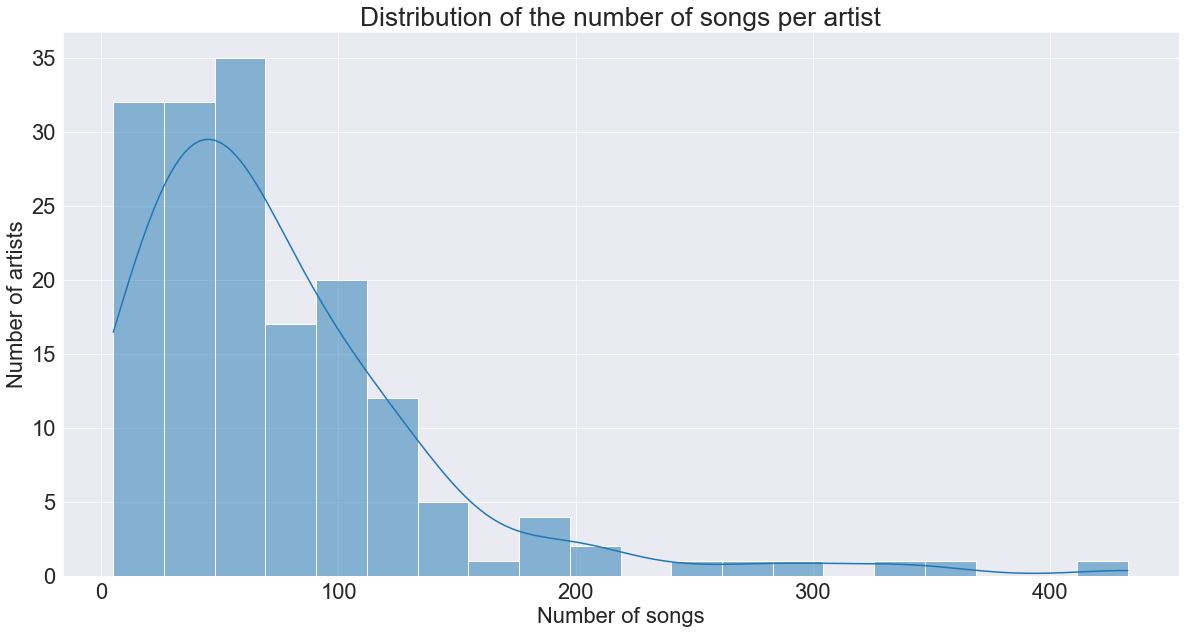

In [36]:
# Plot the distribution of the number of songs per artist
# Get the number of songs per artist
songs_per_artist = unique_df.groupby('artist').count()['lyrics']
# Plot the distribution
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 22})
plt.title('Distribution of the number of songs per artist')
plt.xlabel('Number of songs')
plt.ylabel('Number of artists')
sns.histplot(songs_per_artist, bins=20, kde=True);

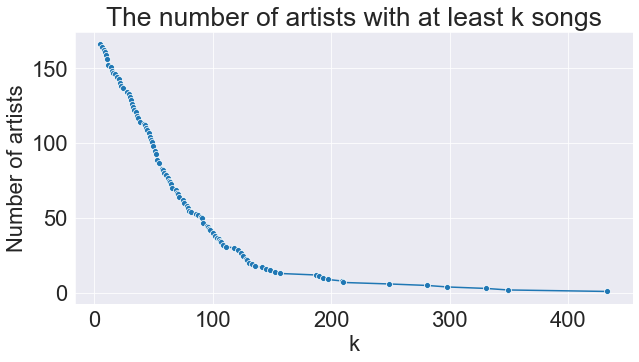

In [37]:
# Plot the number of artists with at least k songs
artists_per_songs = songs_per_artist.value_counts().sort_index(ascending=False)

artists_per_threshold = artists_per_songs.cumsum()

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 22})
plt.title('The number of artists with at least k songs')
plt.xlabel('k')
plt.ylabel('Number of artists')
sns.lineplot(data=artists_per_threshold, marker='o');

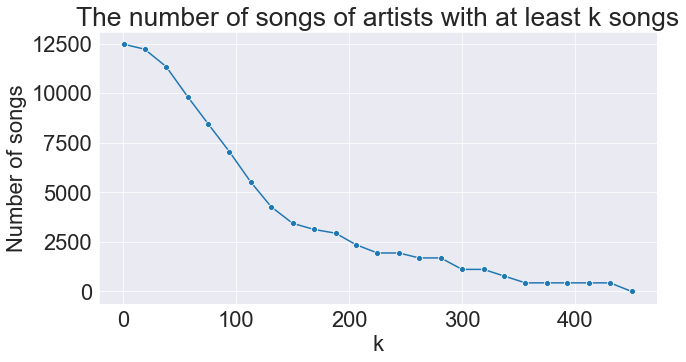

In [38]:
threshold = np.linspace(1, 450, 25, dtype=int)
songs_per_threshold = [(songs_per_artist[songs_per_artist >= threshold]).sum() for threshold in threshold]

plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 22})
plt.title('The number of songs of artists with at least k songs')
plt.xlabel('k')
plt.ylabel('Number of songs')
sns.lineplot(x=threshold, y=songs_per_threshold, marker='o');

We can see that choosing a value of $k=50$ will result in having around 10000 songs and 100 artists, a reasonable dataset and therefore the chosen one.
So with all of our love for `עדן בן זקן`, some must go.
### Being ✨experimental✨
Worry not, we will keep these artists for the experimental part of the project, for example for Zero-Shot-Learning.
Take comfort in the fact that `נועה קירל`  and `מרגי` are together, well at least in `experimental.csv`.

In [39]:
k = 50
counts = unique_df['artist'].value_counts()
artists = counts[counts >= k].index
artists_to_remove = counts[counts < k].index
experimental = unique_df[unique_df['artist'].isin(artists_to_remove)]
experimental.to_csv('./experimental.csv', index=False,encoding = 'utf-8-sig')
unique_df = unique_df[unique_df['artist'].isin(artists)]

artists = unique_df['artist'].unique()
print(f"Total number of artists in experimental: {len(experimental['artist'].unique())}")
print(f"Total number of artists in the updated dataset: {len(unique_df['artist'].unique())}")
print(f"The shape of the updated dataset: {unique_df.shape}")

Total number of artists in experimental: 68
Total number of artists in the updated dataset: 98
The shape of the updated dataset: (10620, 7)


## Splitting the data
One important thing to consider when splitting the data is to keep the ratio of songs by an artist in relation to the total number of songs for each instance of the artist - both in the training set and in the test set.
This is done by using the `stratify` option

In [40]:
from sklearn.model_selection import train_test_split

lyrics = unique_df['lyrics']
artists = unique_df['artist']
all_but_artists = unique_df[['lyrics','song_name','url','words count','unique words count']]

X_train, X_test, y_train, y_test = train_test_split(all_but_artists, artists, test_size=0.2, stratify=artists)

# Save to CSV
train_df = pd.DataFrame(np.c_[ X_train,y_train], columns = ['lyrics','song_name','url','words count','unique words count','artist'])
test_df = pd.DataFrame(np.c_[ X_test,y_test], columns = ['lyrics','song_name','url','words count','unique words count','artist'])

print(f'train shape: {train_df.shape}, test shape: {test_df.shape}')
train_df.to_csv('./train.csv', index=False,encoding = 'utf-8-sig')
test_df.to_csv('./test.csv', index=False,encoding = 'utf-8-sig')

train shape: (8496, 6), test shape: (2124, 6)
